# Code Metrics Analysis
Analyzing project at: /content/zeeguu-api/zeeguu/core/


<unknown>:63: SyntaxWarning: invalid escape sequence '\d'
<unknown>:71: SyntaxWarning: invalid escape sequence '\ '


Project Summary:
---------------
Total Python files: 230
Total Lines of Code: 16229
Total Methods/Functions: 1217
Total Classes: 148
Average Cyclomatic Complexity: 6.40

Most complex file: automatic_gec_tagging.py (Complexity: 109)
Largest file: user.py (LOC: 681)
File with most methods: user.py (Methods: 65)


,file,path,loc,nom,classes,cyclo
127,automatic_gec_tagging.py,/content/zeeguu-api/zeeguu/core/nlp_pipeline\a...,451,7,1,109
104,user.py,/content/zeeguu-api/zeeguu/core/model\user.py,681,65,1,64
105,user_activitiy_data.py,/content/zeeguu-api/zeeguu/core/model\user_act...,387,16,1,54
18,article_downloader.py,/content/zeeguu-api/zeeguu/core/content_retrie...,331,8,0,53
67,bookmark.py,/content/zeeguu-api/zeeguu/core/model\bookmark.py,586,31,1,46
...,...,...,...,...,...,...
217,time_conversion.py,/content/zeeguu-api/zeeguu/core/util\time_conv...,5,1,0,0
215,time.py,/content/zeeguu-api/zeeguu/core/util\time.py,73,4,0,0
218,__init__.py,/content/zeeguu-api/zeeguu/core/util\__init__.py,7,0,0,0
216,timer_logging_decorator.py,/content/zeeguu-api/zeeguu/core/util\timer_log...,12,2,0,0


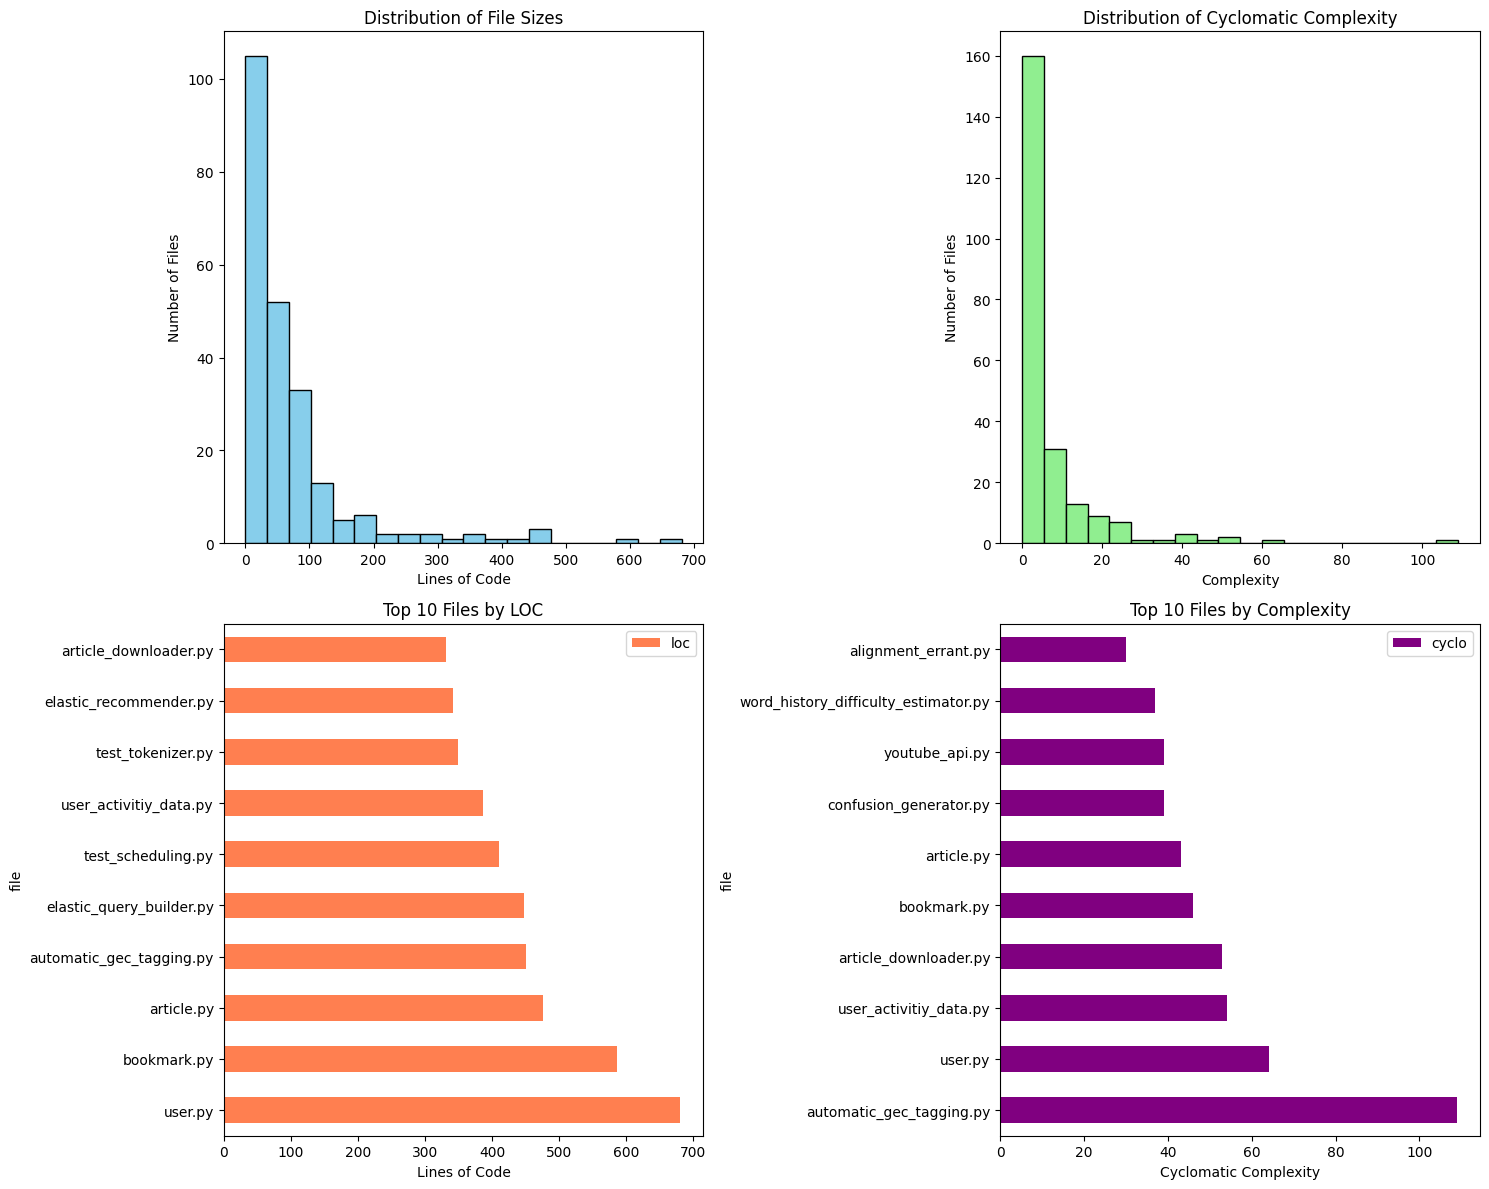

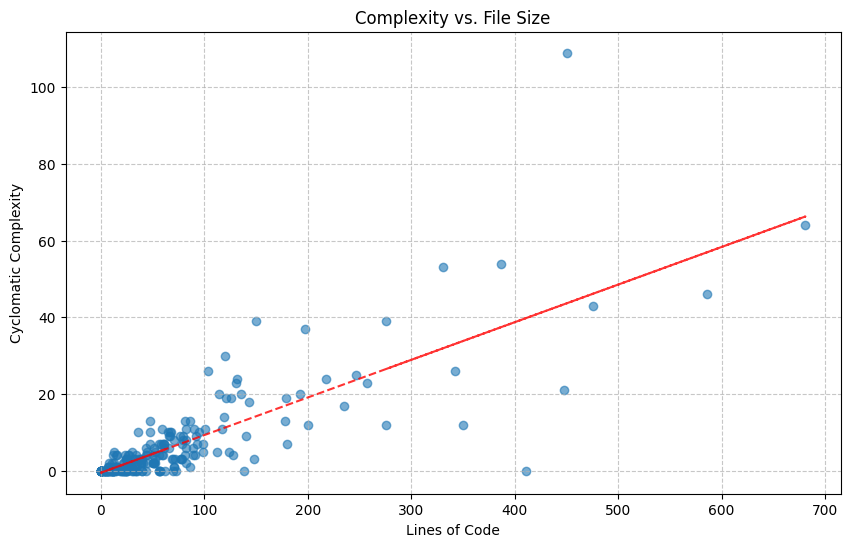


Correlation between metrics:


,loc,nom,cyclo
loc,1.000000,0.834578,0.801898
nom,0.834578,1.000000,0.576693
cyclo,0.801898,0.576693,1.000000


In [25]:
import os
import ast
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys

def count_lines(file_path):
    """Count the number of lines in a file, excluding blank lines and comments."""
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            lines = file.readlines()
            
        # Filter out blank lines and comments
        non_blank_lines = [line.strip() for line in lines 
                          if line.strip() and not line.strip().startswith('#')]
        
        return len(non_blank_lines)
    except Exception as e:
        print(f"Error counting lines in {file_path}: {str(e)}")
        return 0

def analyze_ast(node):
    """
    Analyze an AST node recursively and return metrics.
    Returns (number_of_methods, cyclomatic_complexity)
    """
    # Initialize counters
    methods = 0
    complexity = 0
    
    # Process this node first
    if isinstance(node, (ast.FunctionDef, ast.AsyncFunctionDef, ast.Lambda)):
        methods += 1
    
    if isinstance(node, ast.If) or isinstance(node, ast.IfExp):
        complexity += 1
    
    if isinstance(node, (ast.For, ast.AsyncFor, ast.While)):
        complexity += 1
    
    if isinstance(node, ast.Try):
        complexity += 1
        # Add complexity for each except clause
        complexity += len(node.handlers)
    
    if isinstance(node, ast.BoolOp):
        # Count each additional boolean operation
        complexity += len(node.values) - 1
    
    # Recursively process all child nodes
    for child in ast.iter_child_nodes(node):
        child_methods, child_complexity = analyze_ast(child)
        methods += child_methods
        complexity += child_complexity
    
    return methods, complexity

def compute_file_metrics(file_path):
    """Compute metrics for a single Python file."""
    try:
        # Count lines of code
        loc = count_lines(file_path)
        
        # Parse the file into an AST
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            tree = ast.parse(file.read())
        
        # Analyze the AST
        methods, complexity = analyze_ast(tree)
        
        # Count classes
        classes = sum(1 for node in ast.walk(tree) if isinstance(node, ast.ClassDef))
        
        return {
            'file': os.path.basename(file_path),
            'path': file_path,
            'loc': loc,
            'nom': methods,  # NOM - Number of Methods
            'classes': classes,
            'cyclo': complexity  # Cyclomatic Complexity
        }
    except Exception as e:
        print(f"Error analyzing {file_path}: {str(e)}")
        return {
            'file': os.path.basename(file_path),
            'path': file_path,
            'loc': 0,
            'nom': 0,
            'classes': 0,
            'cyclo': 0,
            'error': str(e)
        }

def analyze_project(project_path, exclude_dirs=None):
    """
    Analyze all Python files in a project directory.
    
    Args:
        project_path: The root path of the project
        exclude_dirs: List of directory names to exclude (e.g., ['venv', 'tests'])
        
    Returns:
        DataFrame containing metrics for all Python files
    """
    if exclude_dirs is None:
        exclude_dirs = ['venv', 'env', '.env', '.venv', '__pycache__']
    
    # Find all Python files
    all_files = []
    for root, dirs, files in os.walk(project_path):
        # Skip excluded directories
        dirs[:] = [d for d in dirs if d not in exclude_dirs]
        
        for file in files:
            if file.endswith('.py'):
                all_files.append(os.path.join(root, file))
    
    # Compute metrics for each file
    results = []
    for file_path in all_files:
        metrics = compute_file_metrics(file_path)
        results.append(metrics)
    
    # Create a DataFrame
    df = pd.DataFrame(results)
    
    return df

def summarize_metrics(df):
    """Generate summary statistics for the metrics."""
    if df.empty:
        return "No Python files found or successfully analyzed."
    
    # Calculate project totals
    total_files = len(df)
    total_loc = df['loc'].sum()
    total_methods = df['nom'].sum()
    total_classes = df['classes'].sum()
    avg_complexity = df['cyclo'].mean()
    
    # Find files with highest metrics
    most_complex_file = df.loc[df['cyclo'].idxmax()] if df['cyclo'].max() > 0 else None
    largest_file = df.loc[df['loc'].idxmax()] if df['loc'].max() > 0 else None
    most_methods_file = df.loc[df['nom'].idxmax()] if df['nom'].max() > 0 else None
    
    print(f"Project Summary:")
    print(f"---------------")
    print(f"Total Python files: {total_files}")
    print(f"Total Lines of Code: {total_loc}")
    print(f"Total Methods/Functions: {total_methods}")
    print(f"Total Classes: {total_classes}")
    print(f"Average Cyclomatic Complexity: {avg_complexity:.2f}")
    print()
    
    if most_complex_file is not None:
        print(f"Most complex file: {most_complex_file['file']} (Complexity: {most_complex_file['cyclo']})")
    if largest_file is not None:
        print(f"Largest file: {largest_file['file']} (LOC: {largest_file['loc']})")
    if most_methods_file is not None:
        print(f"File with most methods: {most_methods_file['file']} (Methods: {most_methods_file['nom']})")
        
    return df

def visualize_metrics(df):
    """Create visualizations of the code metrics."""
    if df.empty:
        print("No data to visualize.")
        return
    
    # Set up the plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Distribution of file sizes (LOC)
    axes[0, 0].hist(df['loc'], bins=20, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Distribution of File Sizes')
    axes[0, 0].set_xlabel('Lines of Code')
    axes[0, 0].set_ylabel('Number of Files')
    
    # 2. Distribution of cyclomatic complexity
    axes[0, 1].hist(df['cyclo'], bins=20, color='lightgreen', edgecolor='black')
    axes[0, 1].set_title('Distribution of Cyclomatic Complexity')
    axes[0, 1].set_xlabel('Complexity')
    axes[0, 1].set_ylabel('Number of Files')
    
    # 3. Top 10 files by LOC
    top_loc = df.nlargest(10, 'loc')
    top_loc.plot.barh(x='file', y='loc', ax=axes[1, 0], color='coral')
    axes[1, 0].set_title('Top 10 Files by LOC')
    axes[1, 0].set_xlabel('Lines of Code')
    
    # 4. Top 10 files by complexity
    top_complex = df.nlargest(10, 'cyclo')
    top_complex.plot.barh(x='file', y='cyclo', ax=axes[1, 1], color='purple')
    axes[1, 1].set_title('Top 10 Files by Complexity')
    axes[1, 1].set_xlabel('Cyclomatic Complexity')
    
    plt.tight_layout()
    plt.show()
    
    # Additional visualization: Scatter plot of complexity vs LOC
    plt.figure(figsize=(10, 6))
    plt.scatter(df['loc'], df['cyclo'], alpha=0.6)
    plt.title('Complexity vs. File Size')
    plt.xlabel('Lines of Code')
    plt.ylabel('Cyclomatic Complexity')
    
    # Add a trend line
    if len(df) > 1:
        z = np.polyfit(df['loc'], df['cyclo'], 1)
        p = np.poly1d(z)
        plt.plot(df['loc'], p(df['loc']), "r--", alpha=0.8)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

def analyze_file(file_path):
    """Analyze a single Python file and return its metrics."""
    if not os.path.exists(file_path):
        return f"File not found: {file_path}"
    
    if not file_path.endswith('.py'):
        return f"Not a Python file: {file_path}"
    
    metrics = compute_file_metrics(file_path)
    print(f"Metrics for {os.path.basename(file_path)}:")
    print(f"  - Lines of Code (LOC): {metrics['loc']}")
    print(f"  - Number of Methods (NOM): {metrics['nom']}")
    print(f"  - Cyclomatic Complexity (CYCLO): {metrics['cyclo']}")
    
    return metrics

# Example usage in a notebook
if 'ipykernel' in sys.modules:
    # Set the project path - update this to your project directory
    PROJECT_PATH = "/content/zeeguu-api/zeeguu/core/"
    # PROJECT_PATH = "/content/zeeguu-api/"
    
    # Example of how to use the analyzer
    print("# Code Metrics Analysis")
    print("Analyzing project at:", PROJECT_PATH)
    
    # Exclude directories you don't want to analyze
    exclude = ['venv', 'env', '.git', '__pycache__', 'tests', 'migrations']
    
    # Run the analysis
    metrics_df = analyze_project(PROJECT_PATH, exclude_dirs=exclude)
    
    # Display summary
    summary_df = summarize_metrics(metrics_df)
    
    # # Run the analysis with PageRank
    # metrics_df, pagerank_df = analyze_project_with_pagerank(
    #     PROJECT_PATH, 
    #     exclude_dirs=exclude,
    #     visualize=True
    # )
    # Show detailed metrics table
    display(metrics_df.sort_values(by='cyclo', ascending=False))
    
    # Create visualizations
    visualize_metrics(metrics_df)
    
    # Calculate correlation between metrics
    print("\nCorrelation between metrics:")
    correlation = metrics_df[['loc', 'nom', 'cyclo']].corr()
    display(correlation)

# Code Metrics Analysis with PageRank
Analyzing project at: /content/zeeguu-api/


<unknown>:84: SyntaxWarning: invalid escape sequence '\-'
<unknown>:63: SyntaxWarning: invalid escape sequence '\d'
<unknown>:71: SyntaxWarning: invalid escape sequence '\ '
<unknown>:84: SyntaxWarning: invalid escape sequence '\-'
<unknown>:63: SyntaxWarning: invalid escape sequence '\d'
<unknown>:71: SyntaxWarning: invalid escape sequence '\ '
<unknown>:84: SyntaxWarning: invalid escape sequence '\-'
<unknown>:63: SyntaxWarning: invalid escape sequence '\d'
<unknown>:71: SyntaxWarning: invalid escape sequence '\ '


project_dependencies.html
Project Summary:
---------------
Total Python files: 379
Total Lines of Code: 25675
Total Methods/Functions: 1698
Total Classes: 161
Average Cyclomatic Complexity: 5.97

Most complex file: automatic_gec_tagging.py (Complexity: 109)
Largest file: user.py (LOC: 681)
File with most methods: user.py (Methods: 65)

# PageRank Analysis
Top 10 most important files according to PageRank:


,file,pagerank,path,loc,nom,classes,cyclo
0,zeeguu\core\model\__init__.py,0.123468,/content/zeeguu-api/zeeguu\core\model\__init__.py,56,0,0,0
1,zeeguu\__init__.py,0.068527,/content/zeeguu-api/zeeguu\__init__.py,0,0,0,0
2,zeeguu\core\word_scheduling\basicSR\basicSR.py,0.053875,/content/zeeguu-api/zeeguu\core\word_schedulin...,235,25,1,17
3,zeeguu\core\__init__.py,0.040257,/content/zeeguu-api/zeeguu\core\__init__.py,0,0,0,0
4,zeeguu\logging\__init__.py,0.020879,/content/zeeguu-api/zeeguu\logging\__init__.py,24,7,0,0
5,zeeguu\core\model\bookmark.py,0.018666,/content/zeeguu-api/zeeguu\core\model\bookmark.py,586,31,1,46
6,zeeguu\core\model\language.py,0.017775,/content/zeeguu-api/zeeguu\core\model\language.py,200,15,1,12
7,zeeguu\api\app.py,0.016171,/content/zeeguu-api/zeeguu\api\app.py,52,1,0,2
8,zeeguu\core\model\learning_cycle.py,0.013950,/content/zeeguu-api/zeeguu\core\model\learning...,4,0,1,0
9,zeeguu\core\model\bookmark_user_preference.py,0.013930,/content/zeeguu-api/zeeguu\core\model\bookmark...,4,0,1,0



# Detailed Metrics


,file,path,loc,nom,classes,cyclo,rel_path
275,automatic_gec_tagging.py,/content/zeeguu-api/zeeguu\core\nlp_pipeline\a...,451,7,1,109,zeeguu\core\nlp_pipeline\automatic_gec_tagging.py
252,user.py,/content/zeeguu-api/zeeguu\core\model\user.py,681,65,1,64,zeeguu\core\model\user.py
253,user_activitiy_data.py,/content/zeeguu-api/zeeguu\core\model\user_act...,387,16,1,54,zeeguu\core\model\user_activitiy_data.py
166,article_downloader.py,/content/zeeguu-api/zeeguu\core\content_retrie...,331,8,0,53,zeeguu\core\content_retriever\article_download...
215,bookmark.py,/content/zeeguu-api/zeeguu\core\model\bookmark.py,586,31,1,46,zeeguu\core\model\bookmark.py
...,...,...,...,...,...,...,...
351,activity.py,/content/zeeguu-api/zeeguu\core\user_statistic...,34,5,0,0,zeeguu\core\user_statistics\activity.py
355,student_overview.py,/content/zeeguu-api/zeeguu\core\user_statistic...,35,1,0,0,zeeguu\core\user_statistics\student_overview.py
375,__init__.py,/content/zeeguu-api/zeeguu\core\word_schedulin...,0,0,0,0,zeeguu\core\word_scheduling\basicSR\__init__.py
0,env_var_defs_default.py,/content/zeeguu-api/env_var_defs_default.py,10,0,0,0,env_var_defs_default.py


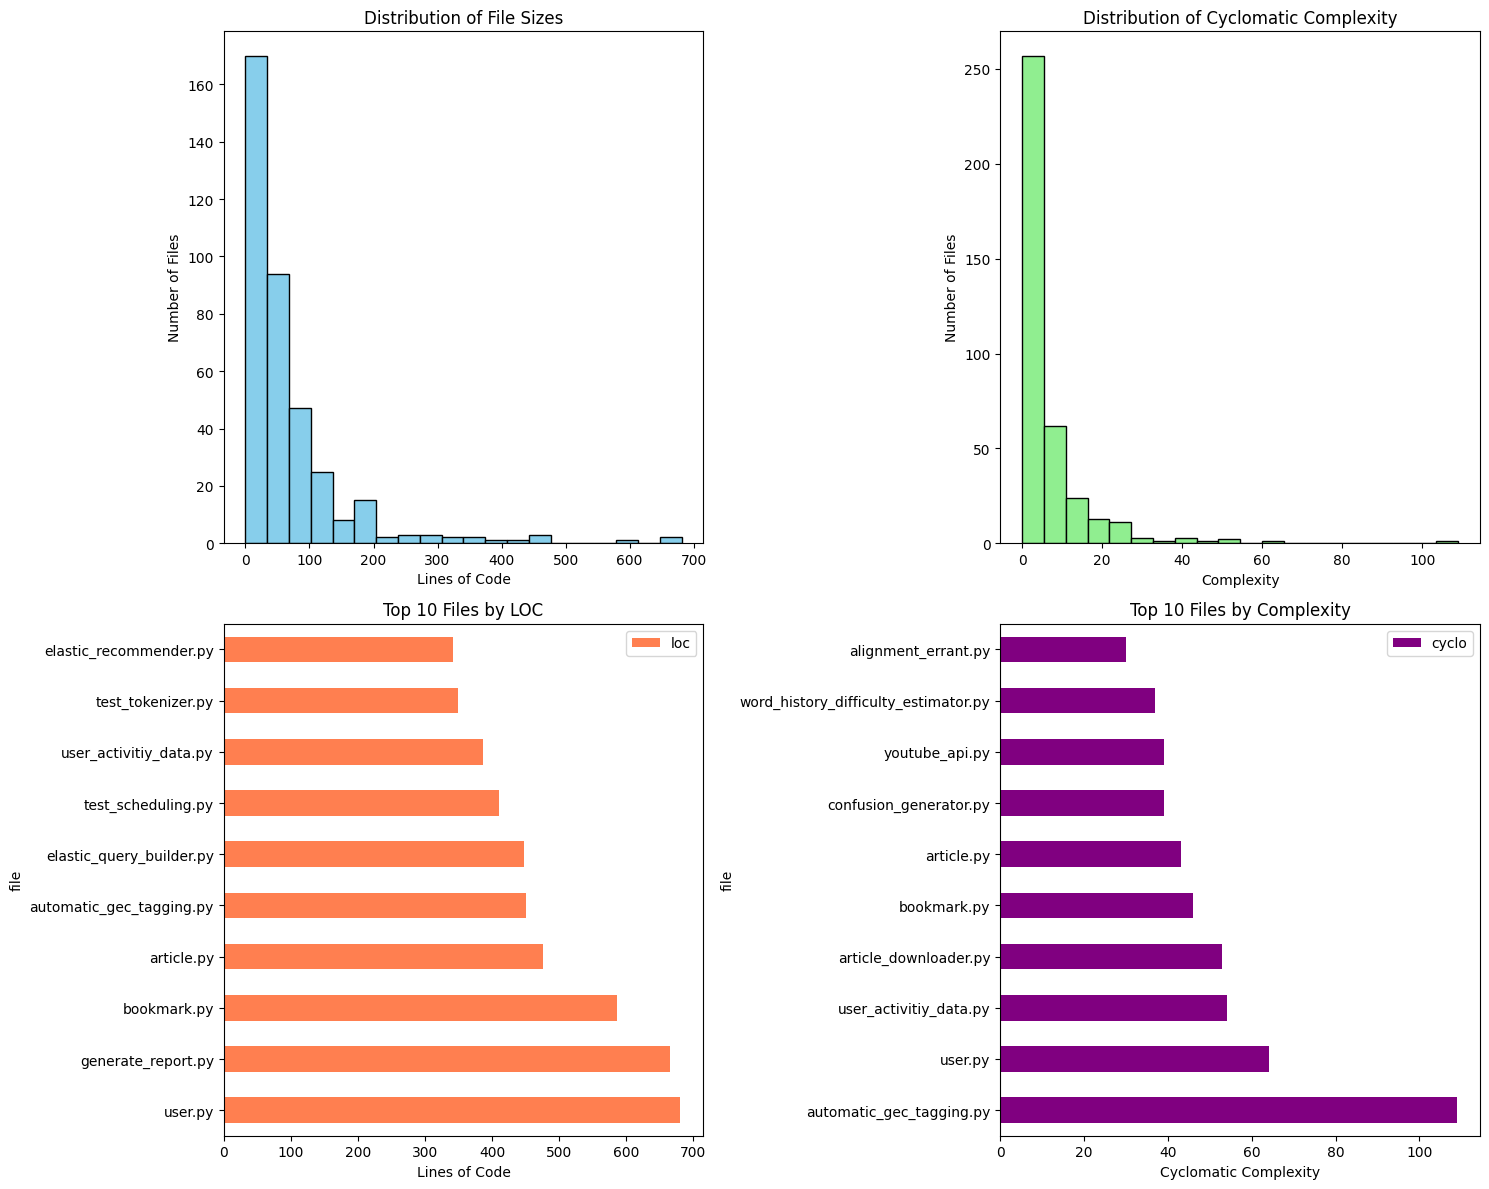

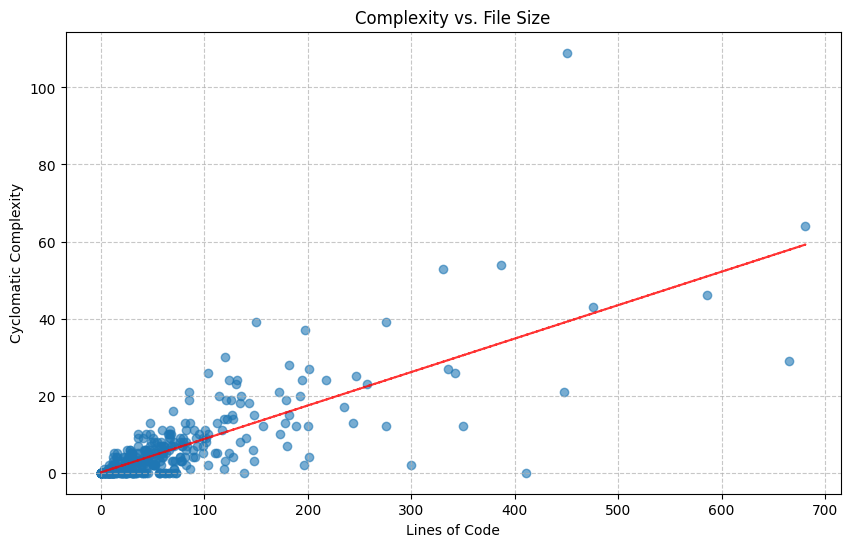


Correlation between metrics (including PageRank):


,pagerank,loc,nom,cyclo
pagerank,1.000000,0.047927,0.064211,0.003868
loc,0.047927,1.000000,0.817852,0.770620
nom,0.064211,0.817852,1.000000,0.546869
cyclo,0.003868,0.770620,0.546869,1.000000


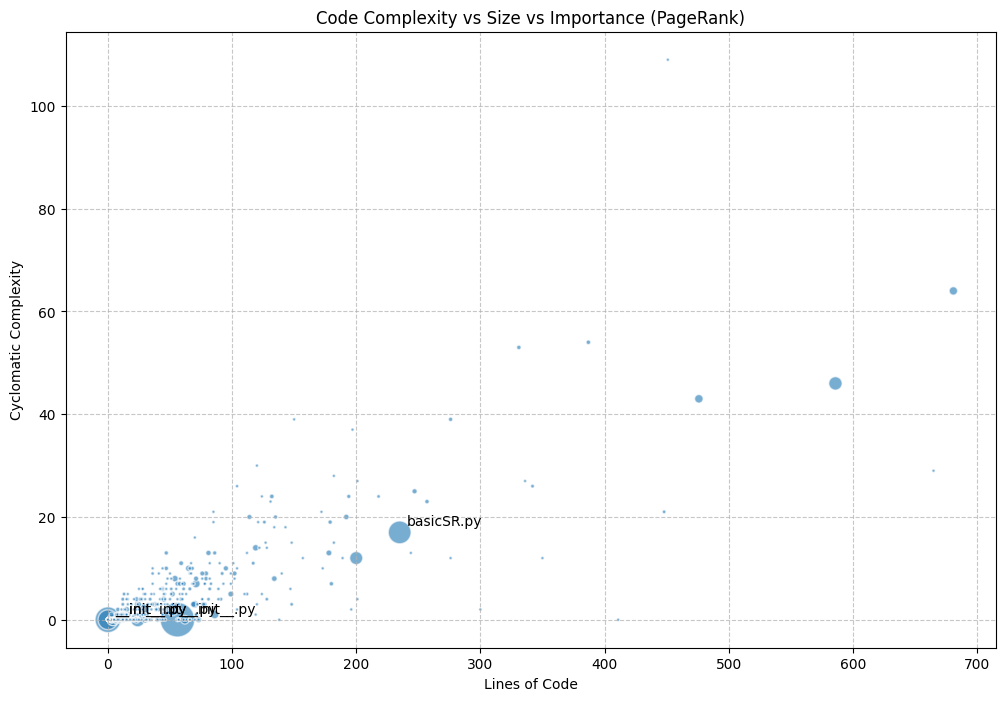

In [ ]:
import os
import ast
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import networkx as nx
from pyvis.network import Network

def count_lines(file_path):
    """Count the number of lines in a file, excluding blank lines and comments."""
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            lines = file.readlines()
            
        # Filter out blank lines and comments
        non_blank_lines = [line.strip() for line in lines 
                          if line.strip() and not line.strip().startswith('#')]
        
        return len(non_blank_lines)
    except Exception as e:
        print(f"Error counting lines in {file_path}: {str(e)}")
        return 0

def analyze_ast(node):
    """
    Analyze an AST node recursively and return metrics.
    Returns (number_of_methods, cyclomatic_complexity)
    """
    # Initialize counters
    methods = 0
    complexity = 0
    
    # Process this node first
    if isinstance(node, (ast.FunctionDef, ast.AsyncFunctionDef, ast.Lambda)):
        methods += 1
    
    if isinstance(node, ast.If) or isinstance(node, ast.IfExp):
        complexity += 1
    
    if isinstance(node, (ast.For, ast.AsyncFor, ast.While)):
        complexity += 1
    
    if isinstance(node, ast.Try):
        complexity += 1
        # Add complexity for each except clause
        complexity += len(node.handlers)
    
    if isinstance(node, ast.BoolOp):
        # Count each additional boolean operation
        complexity += len(node.values) - 1
    
    # Recursively process all child nodes
    for child in ast.iter_child_nodes(node):
        child_methods, child_complexity = analyze_ast(child)
        methods += child_methods
        complexity += child_complexity
    
    return methods, complexity

def compute_file_metrics(file_path):
    """Compute metrics for a single Python file."""
    try:
        # Count lines of code
        loc = count_lines(file_path)
        
        # Parse the file into an AST
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            tree = ast.parse(file.read())
        
        # Analyze the AST
        methods, complexity = analyze_ast(tree)
        
        # Count classes
        classes = sum(1 for node in ast.walk(tree) if isinstance(node, ast.ClassDef))
        
        return {
            'file': os.path.basename(file_path),
            'path': file_path,
            'loc': loc,
            'nom': methods,  # NOM - Number of Methods
            'classes': classes,
            'cyclo': complexity  # Cyclomatic Complexity
        }
    except Exception as e:
        print(f"Error analyzing {file_path}: {str(e)}")
        return {
            'file': os.path.basename(file_path),
            'path': file_path,
            'loc': 0,
            'nom': 0,
            'classes': 0,
            'cyclo': 0,
            'error': str(e)
        }

def analyze_project(project_path, exclude_dirs=None):
    """
    Analyze all Python files in a project directory.
    
    Args:
        project_path: The root path of the project
        exclude_dirs: List of directory names to exclude (e.g., ['venv', 'tests'])
        
    Returns:
        DataFrame containing metrics for all Python files
    """
    if exclude_dirs is None:
        exclude_dirs = ['venv', 'env', '.env', '.venv', '__pycache__']
    
    # Find all Python files
    all_files = []
    for root, dirs, files in os.walk(project_path):
        # Skip excluded directories
        dirs[:] = [d for d in dirs if d not in exclude_dirs]
        
        for file in files:
            if file.endswith('.py'):
                all_files.append(os.path.join(root, file))
    
    # Compute metrics for each file
    results = []
    for file_path in all_files:
        metrics = compute_file_metrics(file_path)
        results.append(metrics)
    
    # Create a DataFrame
    df = pd.DataFrame(results)
    
    return df

def summarize_metrics(df):
    """Generate summary statistics for the metrics."""
    if df.empty:
        return "No Python files found or successfully analyzed."
    
    # Calculate project totals
    total_files = len(df)
    total_loc = df['loc'].sum()
    total_methods = df['nom'].sum()
    total_classes = df['classes'].sum()
    avg_complexity = df['cyclo'].mean()
    
    # Find files with highest metrics
    most_complex_file = df.loc[df['cyclo'].idxmax()] if df['cyclo'].max() > 0 else None
    largest_file = df.loc[df['loc'].idxmax()] if df['loc'].max() > 0 else None
    most_methods_file = df.loc[df['nom'].idxmax()] if df['nom'].max() > 0 else None
    
    print(f"Project Summary:")
    print(f"---------------")
    print(f"Total Python files: {total_files}")
    print(f"Total Lines of Code: {total_loc}")
    print(f"Total Methods/Functions: {total_methods}")
    print(f"Total Classes: {total_classes}")
    print(f"Average Cyclomatic Complexity: {avg_complexity:.2f}")
    print()
    
    if most_complex_file is not None:
        print(f"Most complex file: {most_complex_file['file']} (Complexity: {most_complex_file['cyclo']})")
    if largest_file is not None:
        print(f"Largest file: {largest_file['file']} (LOC: {largest_file['loc']})")
    if most_methods_file is not None:
        print(f"File with most methods: {most_methods_file['file']} (Methods: {most_methods_file['nom']})")
        
    return df

def visualize_metrics(df):
    """Create visualizations of the code metrics."""
    if df.empty:
        print("No data to visualize.")
        return
    
    # Set up the plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Distribution of file sizes (LOC)
    axes[0, 0].hist(df['loc'], bins=20, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Distribution of File Sizes')
    axes[0, 0].set_xlabel('Lines of Code')
    axes[0, 0].set_ylabel('Number of Files')
    
    # 2. Distribution of cyclomatic complexity
    axes[0, 1].hist(df['cyclo'], bins=20, color='lightgreen', edgecolor='black')
    axes[0, 1].set_title('Distribution of Cyclomatic Complexity')
    axes[0, 1].set_xlabel('Complexity')
    axes[0, 1].set_ylabel('Number of Files')
    
    # 3. Top 10 files by LOC
    top_loc = df.nlargest(10, 'loc')
    top_loc.plot.barh(x='file', y='loc', ax=axes[1, 0], color='coral')
    axes[1, 0].set_title('Top 10 Files by LOC')
    axes[1, 0].set_xlabel('Lines of Code')
    
    # 4. Top 10 files by complexity
    top_complex = df.nlargest(10, 'cyclo')
    top_complex.plot.barh(x='file', y='cyclo', ax=axes[1, 1], color='purple')
    axes[1, 1].set_title('Top 10 Files by Complexity')
    axes[1, 1].set_xlabel('Cyclomatic Complexity')
    
    plt.tight_layout()
    plt.show()
    
    # Additional visualization: Scatter plot of complexity vs LOC
    plt.figure(figsize=(10, 6))
    plt.scatter(df['loc'], df['cyclo'], alpha=0.6)
    plt.title('Complexity vs. File Size')
    plt.xlabel('Lines of Code')
    plt.ylabel('Cyclomatic Complexity')
    
    # Add a trend line
    if len(df) > 1:
        z = np.polyfit(df['loc'], df['cyclo'], 1)
        p = np.poly1d(z)
        plt.plot(df['loc'], p(df['loc']), "r--", alpha=0.8)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

def analyze_file(file_path):
    """Analyze a single Python file and return its metrics."""
    if not os.path.exists(file_path):
        return f"File not found: {file_path}"
    
    if not file_path.endswith('.py'):
        return f"Not a Python file: {file_path}"
    
    metrics = compute_file_metrics(file_path)
    print(f"Metrics for {os.path.basename(file_path)}:")
    print(f"  - Lines of Code (LOC): {metrics['loc']}")
    print(f"  - Number of Methods (NOM): {metrics['nom']}")
    print(f"  - Cyclomatic Complexity (CYCLO): {metrics['cyclo']}")
    
    return metrics

# PageRank analysis functions

def extract_imports(file_path, project_path):
    """Extract Python imports from a file and return relative paths within the project."""
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            content = file.read()
        
        # Parse the code into an AST
        tree = ast.parse(content)
        
        # Get all import statements
        imports = []
        for node in ast.walk(tree):
            # Handle 'import x' statements
            if isinstance(node, ast.Import):
                for name in node.names:
                    imports.append(name.name)
            
            # Handle 'from x import y' statements
            elif isinstance(node, ast.ImportFrom) and node.module:
                imports.append(node.module)
        
        # Convert import names to potential file paths within the project
        file_dependencies = []
        for import_name in imports:
            # Convert dot notation to directory structure
            potential_path = import_name.replace('.', os.sep)
            
            # Check for both direct .py file and __init__.py in directory
            py_file = os.path.join(project_path, f"{potential_path}.py")
            init_file = os.path.join(project_path, potential_path, "__init__.py")
            
            if os.path.exists(py_file):
                file_dependencies.append(py_file)
            elif os.path.exists(init_file):
                file_dependencies.append(init_file)
            
            # Handle relative imports within packages
            dir_name = os.path.dirname(file_path)
            for _ in range(potential_path.count('.')+1):
                dir_name = os.path.dirname(dir_name)
                rel_path = os.path.join(dir_name, f"{potential_path.split('.')[-1]}.py")
                if os.path.exists(rel_path):
                    file_dependencies.append(rel_path)
                    break
        
        return file_dependencies
    except Exception as e:
        print(f"Error extracting imports from {file_path}: {str(e)}")
        return []

def build_dependency_graph(python_files, project_path):
    """Build a directed graph of file dependencies based on imports."""
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add all files as nodes
    for file_path in python_files:
        # Use relative path for node name for better readability
        rel_path = os.path.relpath(file_path, project_path)
        G.add_node(rel_path, file_path=file_path)
    
    # Add edges based on imports
    for file_path in python_files:
        source = os.path.relpath(file_path, project_path)
        dependencies = extract_imports(file_path, project_path)
        
        for dep in dependencies:
            if os.path.exists(dep) and dep in python_files:
                target = os.path.relpath(dep, project_path)
                G.add_edge(source, target)
    
    return G

def analyze_pagerank(python_files, project_path, metrics_df=None):
    """
    Build a dependency graph and calculate PageRank for Python files.
    
    Args:
        python_files: List of Python file paths to analyze
        project_path: Root path of the project
        metrics_df: DataFrame with existing metrics (optional)
        
    Returns:
        DataFrame with PageRank scores
    """
    # Build the graph
    G = build_dependency_graph(python_files, project_path)
    
    # Calculate PageRank
    pagerank = nx.pagerank(G, alpha=0.85)
    
    # Create a DataFrame with PageRank results
    pagerank_df = pd.DataFrame({
        'file': list(pagerank.keys()),
        'pagerank': list(pagerank.values())
    }).sort_values(by='pagerank', ascending=False)
    
    # Add file paths
    pagerank_df['path'] = pagerank_df['file'].apply(
        lambda f: os.path.join(project_path, f)
    )
    
    # Merge with metrics if provided
    if metrics_df is not None:
        # Convert to relative paths for joining
        metrics_df['rel_path'] = metrics_df['path'].apply(
            lambda p: os.path.relpath(p, project_path)
        )
        
        # Join the DataFrames
        result_df = pd.merge(
            pagerank_df, 
            metrics_df,
            left_on='file', 
            right_on='rel_path',
            how='left'
        )
        
        # Clean up the merged DataFrame
        if 'file_y' in result_df.columns:
            result_df = result_df.drop(columns=['file_y'])
        if 'path_y' in result_df.columns:
            result_df = result_df.drop(columns=['path_y'])
        if 'rel_path' in result_df.columns:
            result_df = result_df.drop(columns=['rel_path'])
        
        # Rename columns for clarity if needed
        if 'file_x' in result_df.columns:
            result_df = result_df.rename(columns={'file_x': 'file'})
        if 'path_x' in result_df.columns:
            result_df = result_df.rename(columns={'path_x': 'path'})
        
        return result_df
    
    return pagerank_df

def visualize_dependency_graph(G, pagerank=None, filename='dependency_graph.html', height='600px'):
    """
    Visualize the dependency graph using PyVis.
    
    Args:
        G: NetworkX graph object
        pagerank: Dictionary of PageRank values (optional)
        filename: Output HTML file name
        height: Height of the visualization
    """
    # Create PyVis network
    net = Network(height=height, width='100%', directed=True, notebook=True)
    
    # If we have PageRank values, use them to size the nodes
    if pagerank:
        # Scale PageRank for better visualization
        min_size = 10
        max_size = 50
        min_rank = min(pagerank.values())
        max_rank = max(pagerank.values())
        range_rank = max_rank - min_rank
        
        for node in G.nodes():
            size = min_size
            if range_rank > 0 and node in pagerank:
                # Scale the node size based on PageRank
                size = min_size + (pagerank[node] - min_rank) / range_rank * (max_size - min_size)
            
            # Add the node with size and title (showing PageRank value)
            net.add_node(
                node, 
                label=os.path.basename(node), 
                title=f"{node}\nPageRank: {pagerank.get(node, 0):.4f}",
                size=size
            )
    else:
        # Add nodes without PageRank information
        for node in G.nodes():
            net.add_node(node, label=os.path.basename(node), title=node)
    
    # Add all edges
    for edge in G.edges():
        net.add_edge(edge[0], edge[1])
    
    # Set physics layout options
    net.barnes_hut(gravity=-80000, central_gravity=0.3, spring_length=250)
    
    # Save and return the visualization
    net.show(filename)
    return filename

def analyze_project_with_pagerank(project_path, exclude_dirs=None, visualize=True):
    """
    Analyze a project with both code metrics and PageRank.
    
    Args:
        project_path: Root path of the project
        exclude_dirs: List of directory names to exclude
        visualize: Whether to create visualizations
        
    Returns:
        Tuple of (metrics_df, pagerank_df)
    """
    if exclude_dirs is None:
        exclude_dirs = ['venv', 'env', '.env', '.venv', '__pycache__']
    
    # Find all Python files
    all_files = []
    for root, dirs, files in os.walk(project_path):
        # Skip excluded directories
        dirs[:] = [d for d in dirs if d not in exclude_dirs]
        
        for file in files:
            if file.endswith('.py'):
                file_path = os.path.join(root, file)
                all_files.append(file_path)
    
    # Compute standard metrics
    metrics_df = analyze_project(project_path, exclude_dirs)
    
    # Calculate PageRank
    pagerank_df = analyze_pagerank(all_files, project_path, metrics_df)
    
    # Build a graph for visualization
    if visualize and len(all_files) > 0:
        G = build_dependency_graph(all_files, project_path)
        pagerank = nx.pagerank(G, alpha=0.85)
        visualize_dependency_graph(G, pagerank, 'project_dependencies.html')
    
    return metrics_df, pagerank_df

# Example usage in a notebook
if 'ipykernel' in sys.modules:
    # Set the project path - update this to your project directory
    PROJECT_PATH = "/content/zeeguu-api/"   
    # Example of how to use the analyzer
    print("# Code Metrics Analysis with PageRank")
    print("Analyzing project at:", PROJECT_PATH)
    
    # Exclude directories you don't want to analyze
    exclude = ['venv', 'env', '.git', '__pycache__', 'tests', 'migrations']
    
    # Run the analysis with PageRank
    metrics_df, pagerank_df = analyze_project_with_pagerank(
        PROJECT_PATH, 
        exclude_dirs=exclude,
        visualize=True
    )
    
    # Display summary of standard metrics
    summary_df = summarize_metrics(metrics_df)
    
    # Show PageRank results
    print("\n# PageRank Analysis")
    print("Top 10 most important files according to PageRank:")
    display(pagerank_df.head(10))
    
    # Show detailed metrics table
    print("\n# Detailed Metrics")
    display(metrics_df.sort_values(by='cyclo', ascending=False))
    
    # Create standard visualizations
    visualize_metrics(metrics_df)
    
    # Calculate correlation between metrics including PageRank
    print("\nCorrelation between metrics (including PageRank):")
    correlation = pagerank_df[['pagerank', 'loc', 'nom', 'cyclo']].corr()
    display(correlation)
    
    # Create a bubble chart showing PageRank, LOC, and Complexity
    plt.figure(figsize=(12, 8))
    plt.scatter(
        pagerank_df['loc'], 
        pagerank_df['cyclo'],
        s=pagerank_df['pagerank'] * 5000,  # Scale PageRank for bubble size
        alpha=0.6,
        edgecolors='w'
    )
    
    # Add file names as annotations for the top files
    for i, row in pagerank_df.head(5).iterrows():
        plt.annotate(
            os.path.basename(row['file']),
            xy=(row['loc'], row['cyclo']),
            xytext=(5, 5),
            textcoords='offset points'
        )
    
    plt.title('Code Complexity vs Size vs Importance (PageRank)')
    plt.xlabel('Lines of Code')
    plt.ylabel('Cyclomatic Complexity')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()